TODO : generaliser à images 32x32, etc.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.labels[0]

7

In [5]:
mnist.train.images[0][251:260]

array([ 0.        ,  0.        ,  0.        ,  0.54901963,  0.98431379,
        0.99607849,  0.99607849,  0.99607849,  0.99607849], dtype=float32)

/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


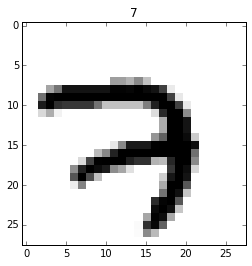

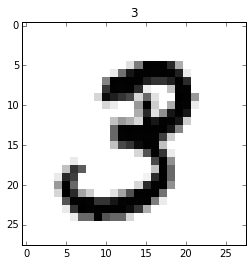

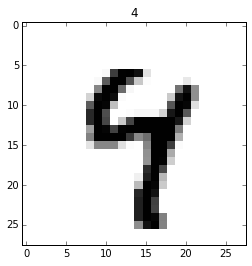

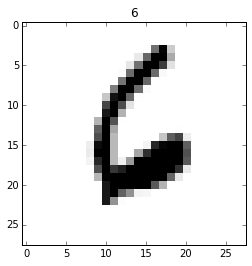

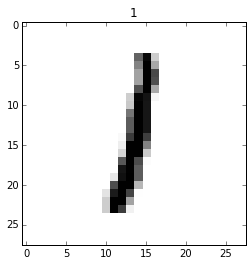

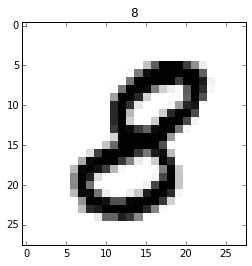

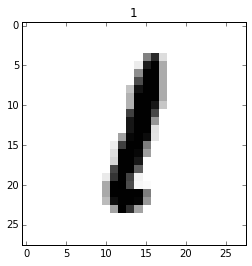

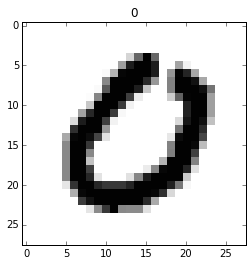

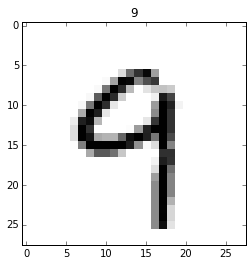

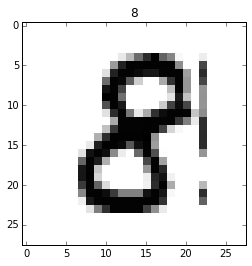

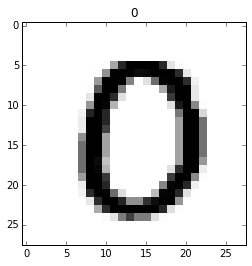

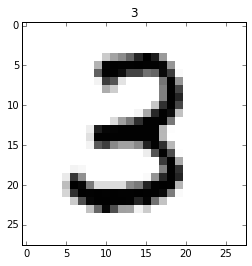

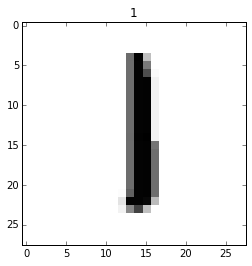

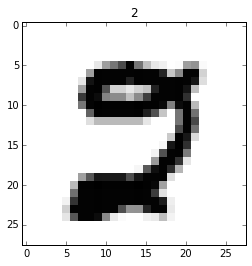

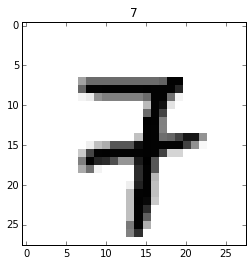

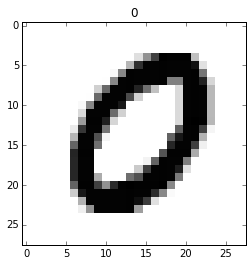

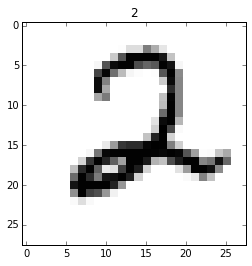

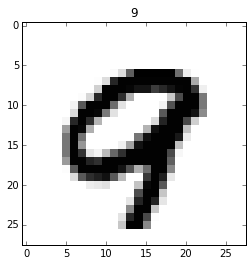

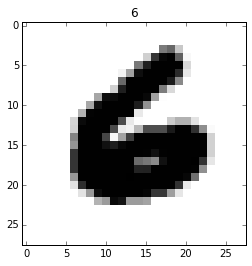

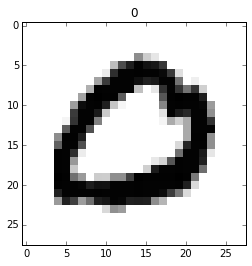

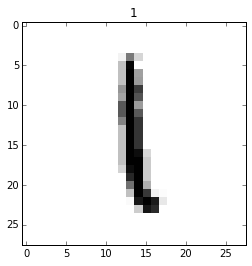

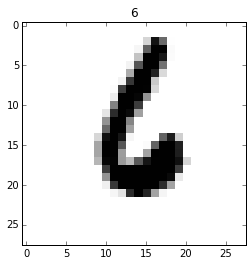

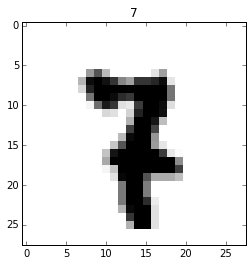

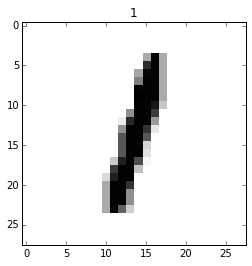

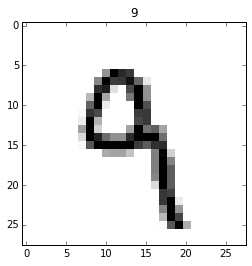

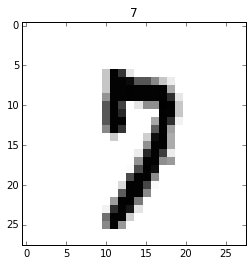

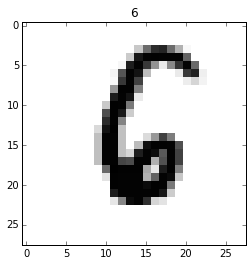

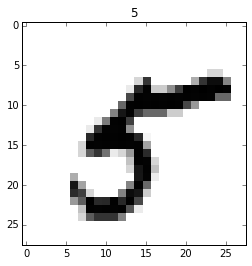

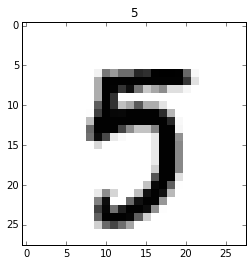

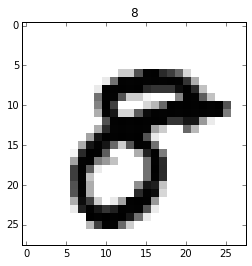

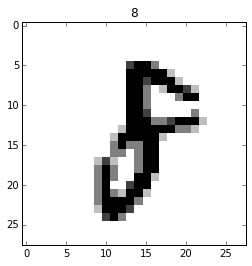

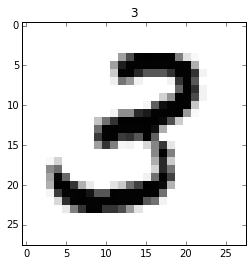

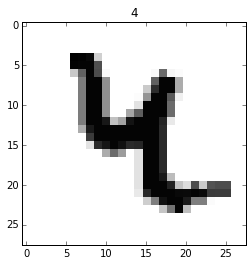

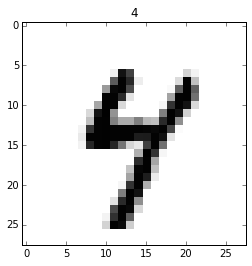

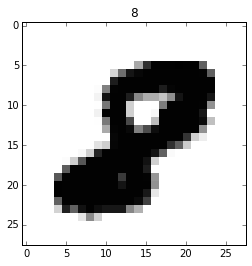

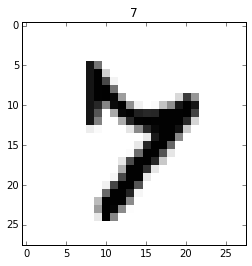

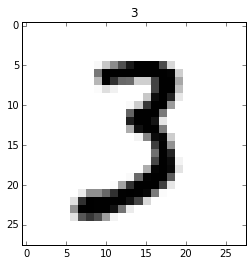

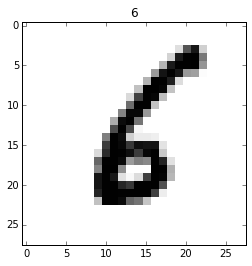

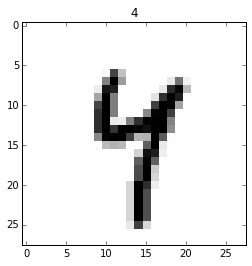

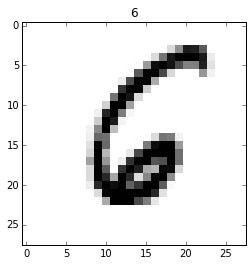

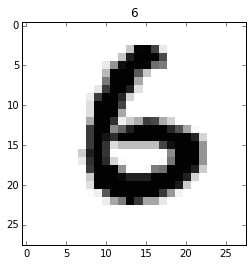

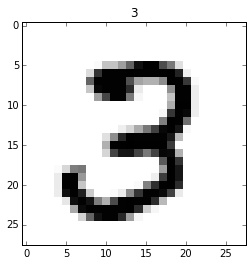

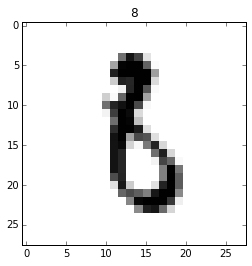

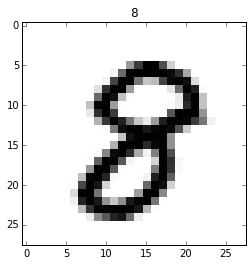

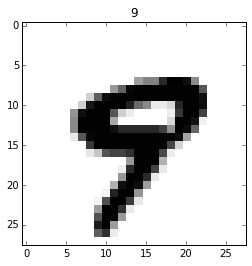

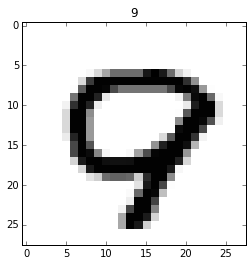

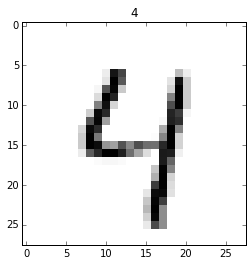

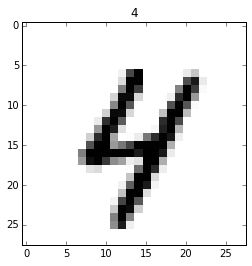

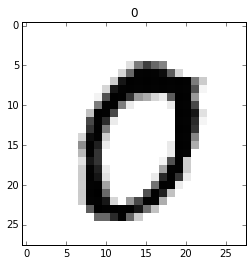

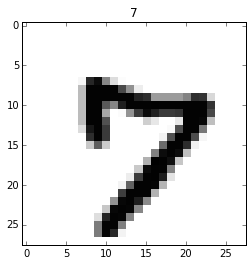

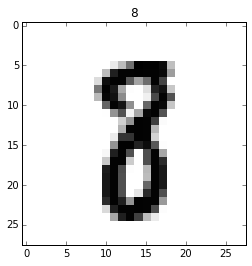

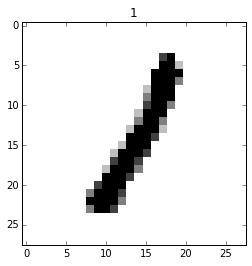

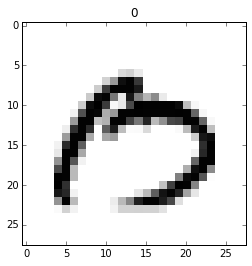

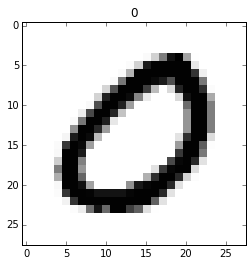

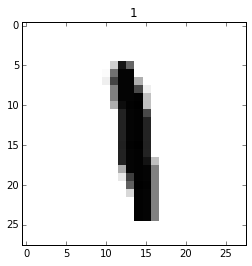

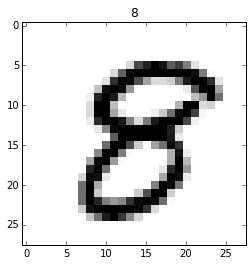

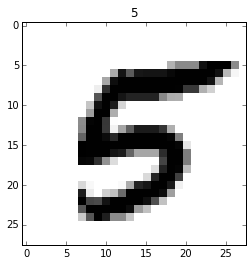

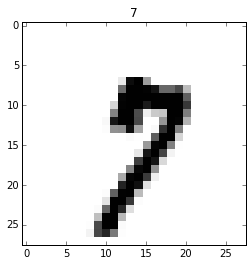

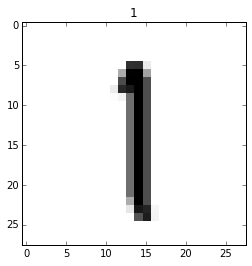

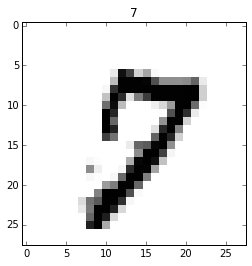

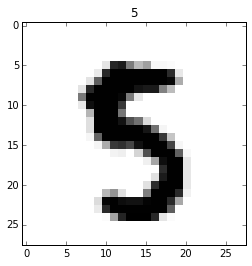

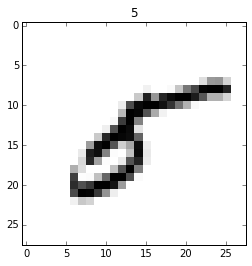

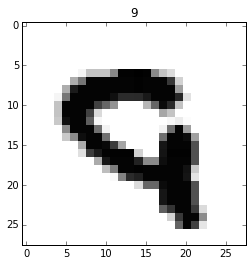

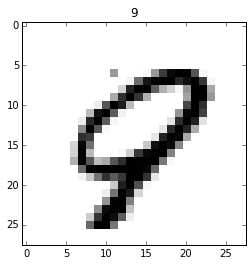

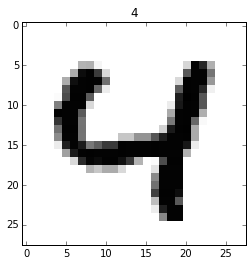

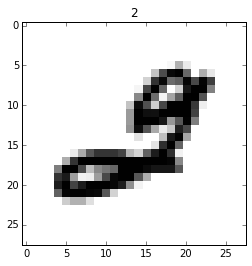

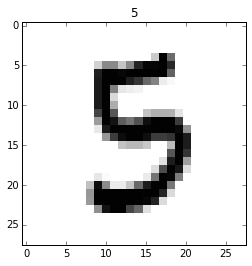

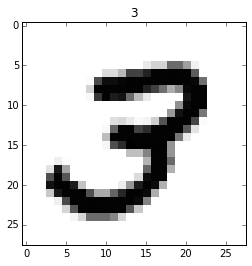

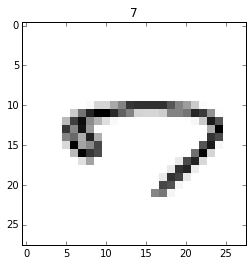

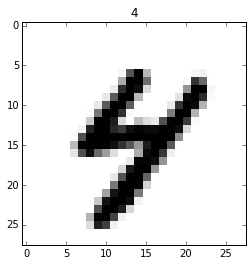

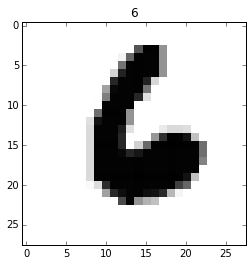

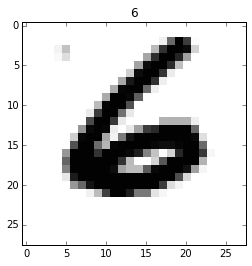

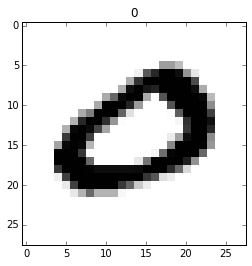

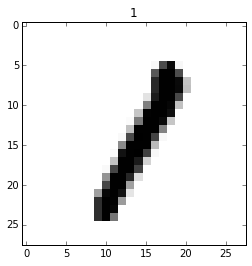

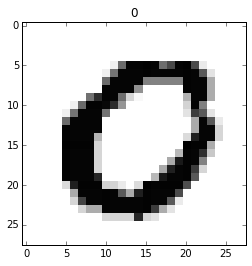

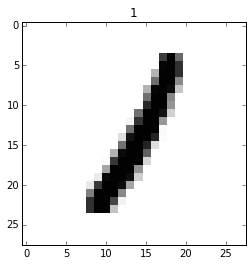

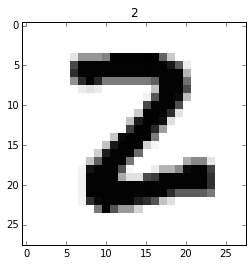

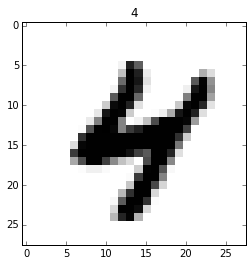

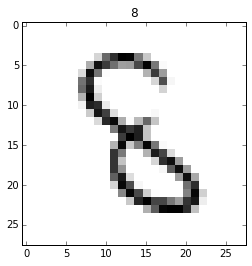

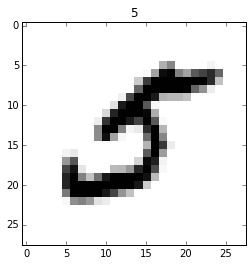

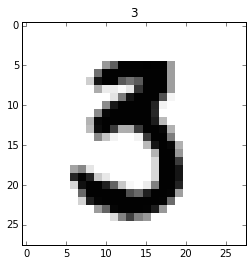

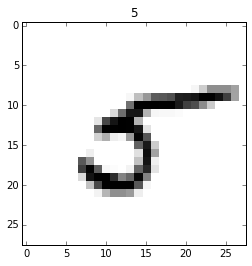

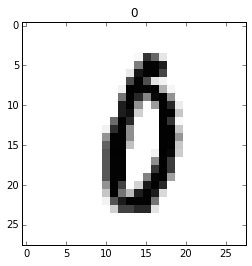

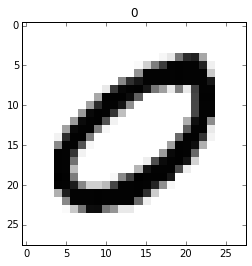

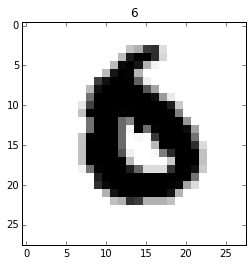

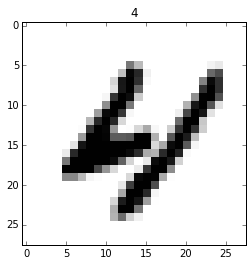

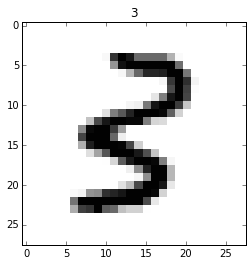

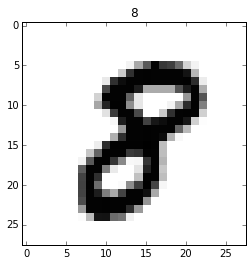

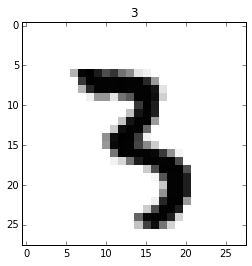

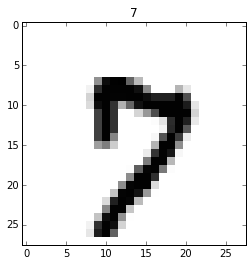

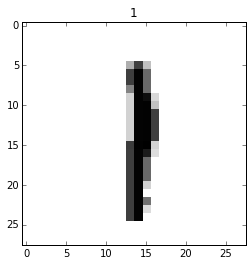

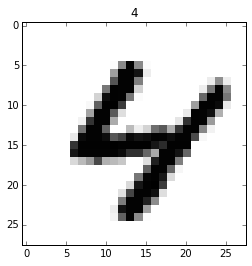

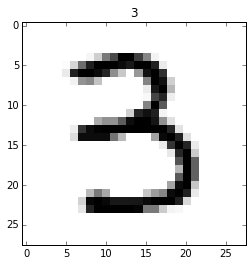

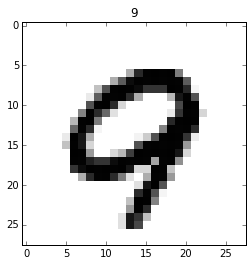

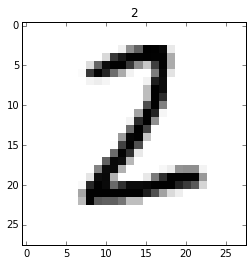

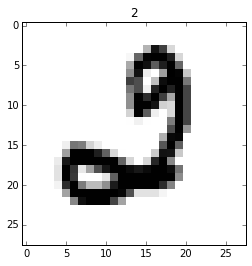

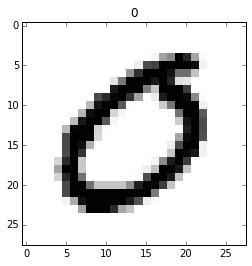

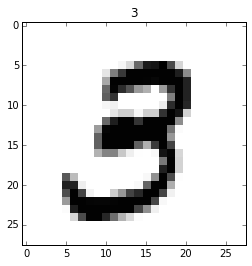

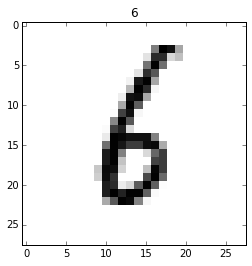

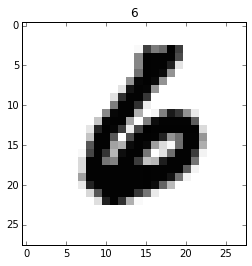

In [6]:
for i in range(100):
    plt.figure()
    plt.imshow(-mnist.train.images[i].reshape(28,28),interpolation='nearest', cmap='gray')
    plt.title(mnist.train.labels[i])

In [7]:
import pywt

In [8]:
data = mnist.train.images[0].reshape(28,28)
coeffs = pywt.wavedec2(data, 'haar')

In [9]:
print 0, coeffs[0].shape
for i in range(1,len(coeffs)):
    print i, coeffs[i][0].shape, coeffs[i][1].shape, coeffs[i][2].shape
print coeffs[0]

0 (2, 2)
1 (2, 2) (2, 2) (2, 2)
2 (4, 4) (4, 4) (4, 4)
3 (7, 7) (7, 7) (7, 7)
4 (14, 14) (14, 14) (14, 14)
[[ 2.39950943  1.76519597]
 [ 1.52745092  2.23480368]]


In [10]:
def init_coeffs_mnist():
    MNIST_SHAPE = [(1, 1), (2, 2), (4, 4), (7, 7), (14, 14)]
    coeffs_zero = [np.zeros((2, 2))]
    for h in range(1 ,5):
        coeffs_zero += [[]]   
        s = MNIST_SHAPE[h]
        for k in range(3) :
            coeffs_zero[h] += [np.zeros(s)]        
    return coeffs_zero    

In [11]:
def add_coeffs_coord(coeffs_ref, coeffs_add, coord):
    v_test = np.array(coeffs_add[0])
    if np.linalg.norm(v_test) < 1e-16:
        coeffs_add[0] = np.copy(coeffs_ref[0])
    for h in range(1,5):
        h_opp = 5 - h
        i = int(coord[0] / 2**h_opp) 
        j = int(coord[1] / 2**h_opp)
        #print i, j
        v_test = np.array([coeffs_add[h][0][i,j], coeffs_add[h][1][i,j], coeffs_add[h][2][i,j]])
        if np.linalg.norm(v_test) < 1e-16:
            for k in range(3) :
                coeffs_add[h][k][i,j] = coeffs_ref[h][k][i,j]
            

In [12]:
def copy_coeffs_mnist(coeffs):
    coeffs_copy = []
    coeffs_copy += [coeffs[0].copy()]
    for h in range(1,5):
        coeffs_copy += [[]]    
        for k in range(3) :
            coeffs_copy[h] += [np.copy(coeffs[h][k])]
    return coeffs_copy    

In [13]:
def calcule_path(coord, axes):
    path_i = []
    path_j = []
    for h in range(0,5):
        h_opp = 5 - h
        coord_i = int(coord[0] / 2**h_opp) 
        coord_j = int(coord[1] / 2**h_opp)    
        path_i += [axes[h][coord_i]]
        path_j += [axes[h][coord_j]]
    return path_i, path_j

In [14]:
def calcule_axes_mnist():
    axes = []
    for h in range(5):
        h_opp = 5 - h
        b_moins = -.5
        b_plus = 27.5
        intervalle = b_plus - b_moins
        coord_max = int(26.5 / 2**h_opp) + 1
        unite = max(intervalle / coord_max, 2**h_opp)
        print unite
        coords = []
        for j in range(coord_max):
            coords += [b_moins + (j+.5) * unite]
        axes += [coords]
    return axes

In [15]:
def ajoute_coeffs(coeffs, v, h, u ):
    if h == -1 :
        coeffs[0][0,0]= v
    elif h == 0:
        coeffs[0][0,1]= v[0]
        coeffs[0][1,0] = v[1]
        coeffs[0][1,1] = v[2]
    else: 
        coeffs[h][0][u[0]][u[1]] = v[0]
        coeffs[h][1][u[0]][u[1]] = v[1]
        coeffs[h][2][u[0]][u[1]] = v[2] 

def calcule_coeffs_mnist(Data, c, i):
    coeffs = init_coeffs_mnist()
    for h in range(-1,5):
        for u in U[h]:
            v = Data[c][h][u][i]
            ajoute_coeffs(coeffs, v, h, u)
    return coeffs
    
def affiche_mnist(Data, c, i): 
    coeffs_aff = calcule_coeffs_mnist(Data, c, i)
    plt.imshow(-pywt.waverec2(coeffs_aff, 'haar'), interpolation='nearest', cmap='gray')

def affiche_mnist_coord(Data, coeffs_aff, c, i, coord):
    coeffs_ref = calcule_coeffs_mnist(Data, c, i)
    add_coeffs_coord(coeffs_ref, coeffs_aff, coord)
    plt.imshow(-pywt.waverec2(coeffs_aff, 'haar'), interpolation='nearest', cmap='gray')
    '''axes = calcule_axes_mnist()
    path_i, path_j = calcule_path(coord, axes)
    plt.plot(path_j,path_i,'r')
    plt.plot(path_j,path_i,'r+',markersize=12)
    plt.plot(coord[1],coord[0],'+',color='r',markersize=12)
    plt.xlim([b_moins,b_plus])
    plt.ylim([b_moins,b_plus])
    plt.gca().invert_yaxis()'''

def affiche_path_mnist(path_i, path_j):
    col_max = max(15, len(path_i))
    colors = plt.cm.rainbow(np.linspace(0, 1, col_max))
    b_moins = -.5
    b_plus = 27.5
    for cpt in range(len(path_i) - 1):
        plt.plot(path_j[cpt:cpt + 2],path_i[cpt:cpt + 2], color = colors[col_max - cpt - 1], linewidth= 3)
    #plt.plot(path_j,path_i,'r+',markersize=12)
    plt.xlim([b_moins,b_plus])
    plt.ylim([b_moins,b_plus])
    plt.gca().invert_yaxis()

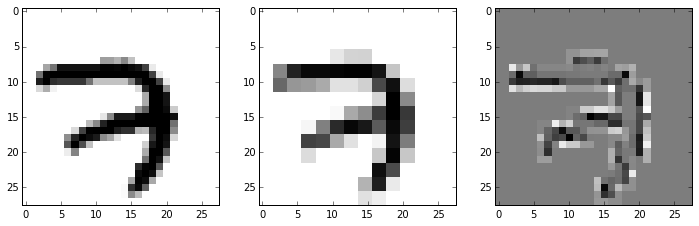

In [16]:
coeffs_test = copy_coeffs_mnist(coeffs)
coeffs_zero = init_coeffs_mnist()
        
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(-pywt.waverec2(coeffs_test, 'haar'), interpolation='nearest', cmap='gray')

for k in range(3) :
    coeffs_test[4][k] *= 0
    coeffs_zero[4][k] = np.copy(coeffs[4][k])
    
plt.subplot(132)
plt.imshow(-pywt.waverec2(coeffs_test, 'haar'), interpolation='nearest', cmap='gray')

plt.subplot(133)
plt.imshow(-pywt.waverec2(coeffs_zero, 'haar'), interpolation='nearest', cmap='gray')

In [17]:
axes = []
for h in range(0,5):
    h_opp = 5 - h
    b_moins = -.5
    b_plus = 27.5
    intervalle = b_plus - b_moins
    coord_max = int(26.5 / 2**h_opp) + 1
    unite = max(intervalle / coord_max, 2**h_opp)
    print unite
    coords = []
    for j in range(coord_max):
        coords += [b_moins + (j+.5) * unite]
    axes += [coords]
print axes
print ''

U = {-1 : {-1 : -1}}
print 'Niveau -1 :'
print 'U[-1] :', U[-1]
print ''
for h in range(len(axes)):
    #U_ref = {}
    #for pos_i in axes[h]:
    #    for pos_j in axes[h]:
    #        U_ref[h] += [(pos_i, pos_j)]
    U [h] = {}
    for i in range(len(axes[h])):
        for j in range(len(axes[h])):
            U[h][(i,j)] = (axes[h][i], axes[h][j])    
    print 'Niveau ', h, ' : '
    print ' U[' , h, '] :', U[h]
    #print ' U_ref[h] :', U_ref[h]
    print ''
    
bsup = [1,2,4,7,14, 0]

def fils_rec(h,i,j):
    if h < 5 and i < bsup[h] and j < bsup[h] :
        rep = [(h,(i,j)), [], [], [], []]
        rep[1] = fils_rec(h+1,i*2, j*2)
        rep[2] = fils_rec(h+1,i*2, j*2 + 1)
        rep[3] = fils_rec(h+1,i*2 + 1, j*2)
        rep[4] = fils_rec(h+1,i*2 + 1, j*2 + 1)
    else:
        rep = []
    return rep
    
U_tree = fils_rec(0,0,0) 

print U_tree


32
16
8
4.0
2.0
[[15.5], [7.5, 23.5], [3.5, 11.5, 19.5, 27.5], [1.5, 5.5, 9.5, 13.5, 17.5, 21.5, 25.5], [0.5, 2.5, 4.5, 6.5, 8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5, 22.5, 24.5, 26.5]]

Niveau -1 :
U[-1] : {-1: -1}

Niveau  0  : 
 U[ 0 ] : {(0, 0): (15.5, 15.5)}

Niveau  1  : 
 U[ 1 ] : {(0, 1): (7.5, 23.5), (1, 0): (23.5, 7.5), (0, 0): (7.5, 7.5), (1, 1): (23.5, 23.5)}

Niveau  2  : 
 U[ 2 ] : {(0, 1): (3.5, 11.5), (1, 2): (11.5, 19.5), (3, 2): (27.5, 19.5), (0, 0): (3.5, 3.5), (3, 3): (27.5, 27.5), (3, 0): (27.5, 3.5), (3, 1): (27.5, 11.5), (2, 1): (19.5, 11.5), (0, 2): (3.5, 19.5), (2, 0): (19.5, 3.5), (1, 3): (11.5, 27.5), (2, 3): (19.5, 27.5), (2, 2): (19.5, 19.5), (1, 0): (11.5, 3.5), (0, 3): (3.5, 27.5), (1, 1): (11.5, 11.5)}

Niveau  3  : 
 U[ 3 ] : {(1, 3): (5.5, 13.5), (6, 6): (25.5, 25.5), (3, 0): (13.5, 1.5), (5, 4): (21.5, 17.5), (2, 1): (9.5, 5.5), (5, 6): (21.5, 25.5), (2, 6): (9.5, 25.5), (1, 6): (5.5, 25.5), (5, 1): (21.5, 5.5), (2, 5): (9.5, 21.5), (0, 3): (1.5, 13.5)

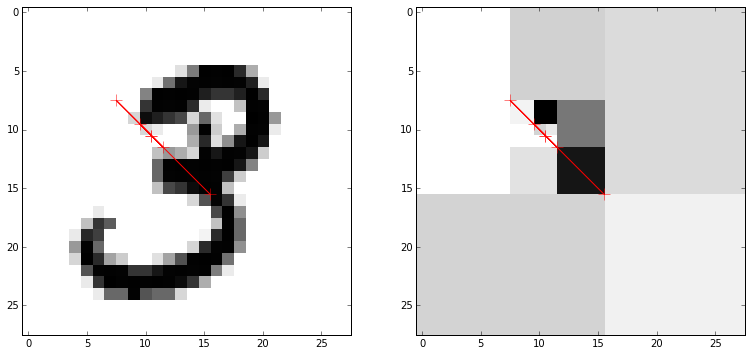

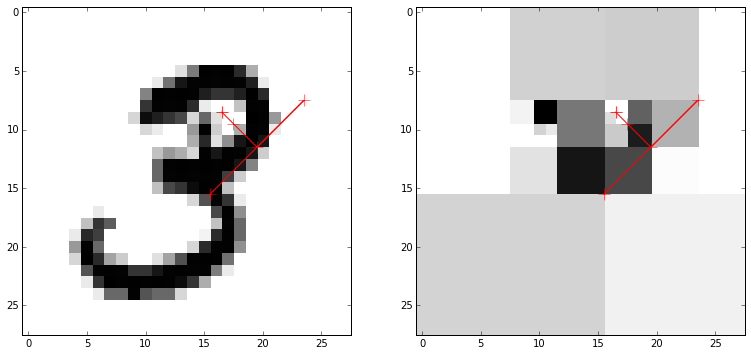

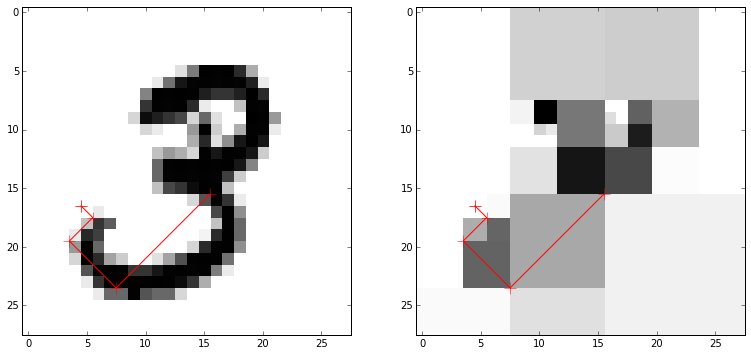

In [18]:
#coord = (10.5,10.5)
#coord = (8.5,16.5)
#coord = (16.5,4.5)

t = 1

data = mnist.train.images[t].reshape(28,28)
coeffs = pywt.wavedec2(data, 'haar')

coeffs_coord = init_coeffs_mnist()

for coord in [(10.5,10.5), (8.5,16.5), (16.5,4.5)]:
    add_coeffs_coord(coeffs, coeffs_coord, coord)

    plt.figure(figsize=(20,12))

    path_i, path_j = calcule_path(coord, axes)

    plt.subplot(131)
    plt.imshow(-pywt.waverec2(coeffs, 'haar'), interpolation='nearest', cmap='gray')
    #for u in U_ref:
    #    plt.plot(u[1],u[0],'+',color='b',markersize=12)
    plt.plot(path_j,path_i,'r')
    plt.plot(path_j,path_i,'r+',markersize=12)
    plt.plot(coord[1],coord[0],'+',color='r',markersize=12)
    plt.xlim([b_moins,b_plus])
    plt.ylim([b_moins,b_plus])
    plt.gca().invert_yaxis()

    plt.subplot(132)
    plt.imshow(-pywt.waverec2(coeffs_coord, 'haar'), interpolation='nearest', cmap='gray')
    plt.plot(path_j,path_i,'r')
    plt.plot(path_j,path_i,'r+',markersize=12)
    plt.plot(coord[1],coord[0],'+',color='r',markersize=12)
    plt.xlim([b_moins,b_plus])
    plt.ylim([b_moins,b_plus])
    plt.gca().invert_yaxis()


## Creation de la base d'apprentissage

In [19]:
len(mnist.train.images)

55000

In [20]:
B = []
for i in range(len(mnist.train.images)):
    c = mnist.train.labels[i]
    x = mnist.train.images[i].reshape(28,28)
    coeffs = pywt.wavedec2(x, 'haar')
    u_m1 = -1
    v_m1 = coeffs[0][0][0]
    B += [(v_m1,(c, -1, u_m1))]
    u0 = (0,0) #U[0][0]
    v0 = np.array([coeffs[0][0][1], coeffs[0][1][0], coeffs[0][1][1]])
    B += [(v0,(c, 0, u0))]
    for h in range(1,5):
        for u in U[h]:
            #v = np.array([coeffs[h][0][u[1]][u[2]], coeffs[h][1][u[1]][u[2]], coeffs[h][2][u[1]][u[2]]])
            v = np.array([coeffs[h][0][u[0]][u[1]], coeffs[h][1][u[0]][u[1]], coeffs[h][2][u[0]][u[1]]])
            #if np.linalg.norm(v) > 1e-16:
            #B += [(v,(c,u))]
            B += [(v,(c,h,u))]            

## Base de test

In [21]:
B_test = []
for i in range(len(mnist.test.images)):
    c = mnist.test.labels[i]
    x = mnist.test.images[i].reshape(28,28)
    coeffs = pywt.wavedec2(x, 'haar')
    u_m1 = -1
    v_m1 = coeffs[0][0][0]
    B_test += [(v_m1,(c, -1, u_m1))]
    u0 = (0,0) #U[0][0]
    v0 = np.array([coeffs[0][0][1], coeffs[0][1][0], coeffs[0][1][1]])
    B_test += [(v0,(c, 0, u0))]
    for h in range(1,5):
        for u in U[h]:
            #v = np.array([coeffs[h][0][u[1]][u[2]], coeffs[h][1][u[1]][u[2]], coeffs[h][2][u[1]][u[2]]])
            v = np.array([coeffs[h][0][u[0]][u[1]], coeffs[h][1][u[0]][u[1]], coeffs[h][2][u[0]][u[1]]])
            #if np.linalg.norm(v) > 1e-16:
            #B += [(v,(c,u))]
            B_test += [(v,(c,h,u))]            

## Test images simple

In [22]:
data_visu = [[],[],[],[],[],[],[],[],[],[]]
for i in range(len(mnist.train.images)):
    c = mnist.train.labels[i]
    x = mnist.train.images[i].reshape(28,28)
    data_visu[c] += [x]


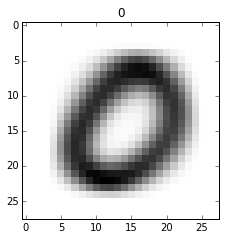

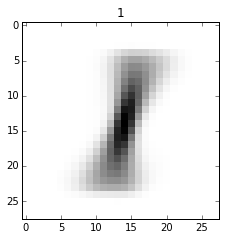

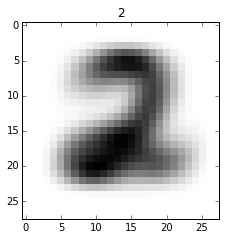

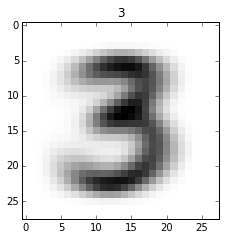

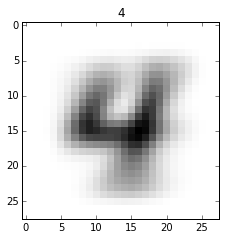

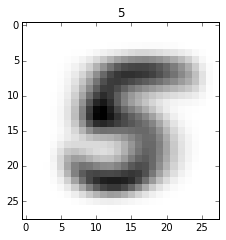

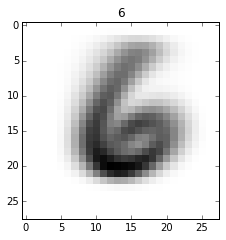

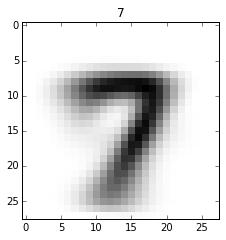

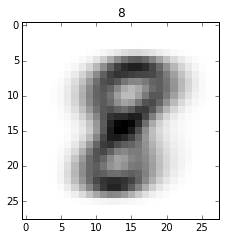

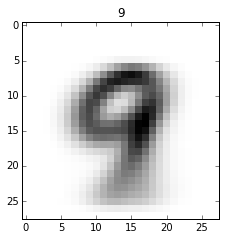

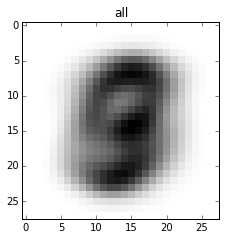

In [23]:
image_moy_moy = np.zeros((28,28))
lin_mnist = []
for c in range(10):
    image_moy = np.mean(np.array(data_visu[c]),0)
    lin_mnist += [image_moy.reshape(28 * 28)]
    image_moy_moy += image_moy
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.imshow(-image_moy, interpolation='nearest', cmap='gray')
    plt.title(c)
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(-image_moy_moy, interpolation='nearest', cmap='gray')
plt.title('all')

## Dictionnaire (Base d'apprentissage)

In [24]:
Data = [[],[],[],[],[],[],[],[],[],[]]
for c in range(10):
    Data[c] = [{},{},{},{},{}] 
    
for d in B:
    v = d[0]
    c = d[1][0]
    h = d[1][1]
    u = d[1][2]
    if u in Data[c][h]:
        Data[c][h][u] += [v]
    else:
        Data[c][h][u] = [v]


## Dictionnaire (Base de test)

In [25]:
Data_test = [[],[],[],[],[],[],[],[],[],[]]
for c in range(10):
    Data_test[c] = [{},{},{},{},{}] 
    
for d in B_test:
    v = d[0]
    c = d[1][0]
    h = d[1][1]
    u = d[1][2]
    if u in Data_test[c][h]:
        Data_test[c][h][u] += [v]
    else:
        Data_test[c][h][u] = [v]


In [26]:
print np.mean(Data[0][0][(0,0)],0)
print np.mean(Data[0][1][(0,0)],0)
print np.mean(Data[0][1][(0,1)],0)
print np.mean(Data[0][2][(0,0)],0)
print np.mean(Data[0][2][(0,1)],0)


[ 2.35478973  2.46233153  1.25776315]
[-1.27351904 -1.81026828  0.58487535]
[-0.97309089  2.17159939 -0.80081075]
[-0.01363159 -0.01381042  0.01355992]
[-1.22357678 -0.67644197  0.66505671]


In [27]:
print Data[5][0][(0,0)]

[array([ 1.99656844,  2.45710778,  0.03014706], dtype=float32), array([ 1.46985281,  1.73651946,  1.07009804], dtype=float32), array([ 2.79215693,  2.55955863,  1.24191177], dtype=float32), array([ 0.82965684,  1.41960764,  1.78284299], dtype=float32), array([ 1.24289203,  1.49656868,  0.        ], dtype=float32), array([ 1.45441163,  1.44901943,  1.01593125], dtype=float32), array([ 1.83897054,  2.17499995,  0.20612742], dtype=float32), array([ 1.26323509,  1.31274509,  0.03308823], dtype=float32), array([ 2.25514698,  2.03210783,  0.25024506], dtype=float32), array([ 1.46299005,  1.27598023,  0.30171567], dtype=float32), array([ 1.32818627,  1.32230389,  0.        ], dtype=float32), array([ 0.8458333 ,  1.47205889,  1.3938725 ], dtype=float32), array([ 1.36813712,  1.47524476,  0.50441176], dtype=float32), array([ 0.32818624,  0.84191179,  0.96715689], dtype=float32), array([ 1.66176462,  1.83333325,  1.09681368], dtype=float32), array([ 1.92181361,  1.60784316,  0.74166667], dtype=f

In [28]:
c = 1
h = -1
i = 0
j = 0
len(Data[c][h][(i,j)])

6179

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


'for angle in range(0, 360):\n    ax.view_init(30, angle)\n    plt.draw()\n    plt.pause(.001)'

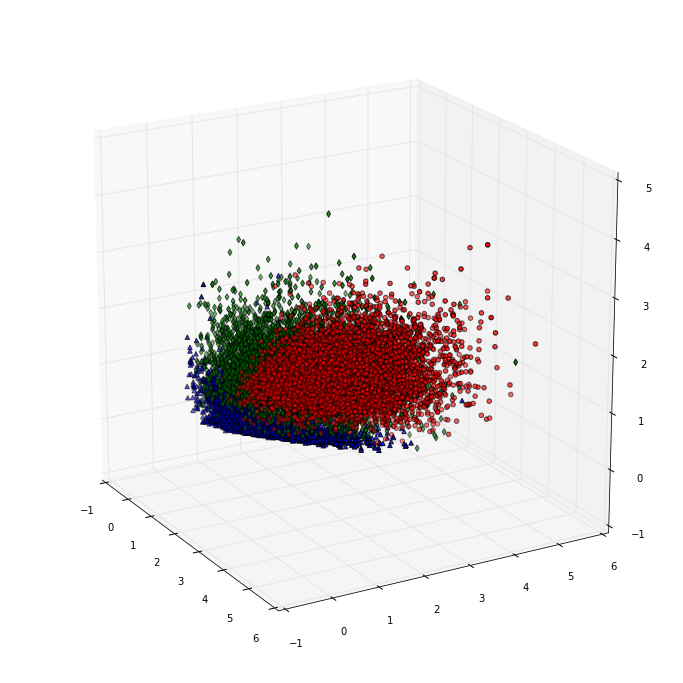

In [29]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')

h = 0 #4
i = 0 #5
j = 0 #5

test = np.array(Data[0][h][(i,j)])
ax.scatter(test[:,0], test[:,1], test[:,2],c='r', marker = 'o')

test2 = np.array(Data[1][h][(i,j)])
ax.scatter(test2[:,0], test2[:,1], test2[:,2],c='b', marker = '^')

test3 = np.array(Data[3][h][(i,j)])
ax.scatter(test3[:,0], test3[:,1], test3[:,2],c='g', marker = 'd')

ax.view_init(20, -30)

'''for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)'''

## Probas elementaires 

In [30]:
mu = []
Sigma = []
rho = []
for c in range(10):
    mu += [{}]
    Sigma += [{}]
    rho += [{}]
    for h in range(-1,5):
        mu[c][h] = {}
        Sigma[c][h] = {}
        rho[c][h] = {}
        for u in U[h]:
            if u in Data[c][h]:
                data = []
                cpt = 0
                for v in Data[c][h][u]:
                    if np.linalg.norm(v) < 1e-16:
                        cpt += 1
                    else:
                        data += [v]
                if h == -1 :
                    print len(data)
                if len(data) > 1:
                    mu[c][h][u] = np.mean(data, 0) #Data[c][h][u],0)
                    Sigma[c][h][u] = np.cov(np.array(data).T) #Data[c][h][u]).T)
                    rho[c][h][u] = float(cpt) / len(Data[c][h][u])
                else:
                    mu[c][h][u] = np.zeros(3)
                    Sigma[c][h][u] = np.zeros((3,3))
                    rho[c][h][u] = 1.
            

5444
6179
5469
5638
5307
4987
5417
5715
5389
5454


In [31]:
c = 0
h = -1 # 4
u = -1 #(12,12)
print mu[c][h][u]
print Sigma[c][h][u]
print rho[c][h][u]


2.52676
0.523746012991
0.0


In [32]:
mu[0][-1][-1]

2.5267594

## Reconstruction


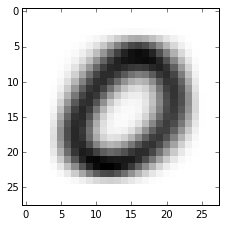

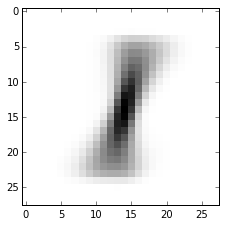

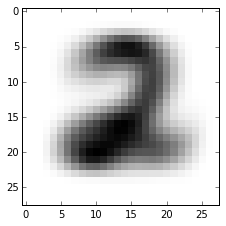

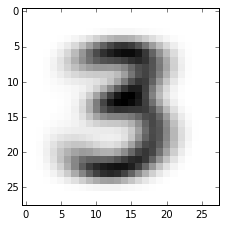

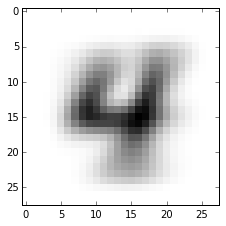

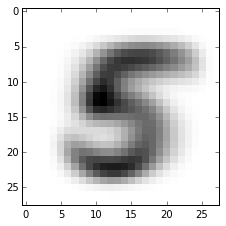

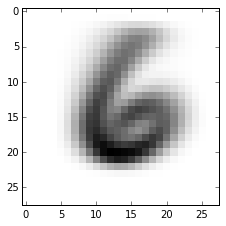

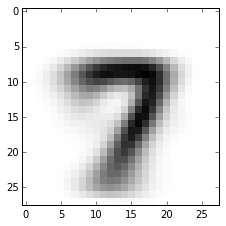

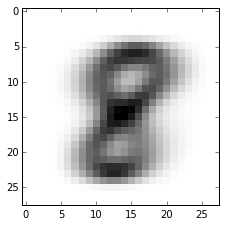

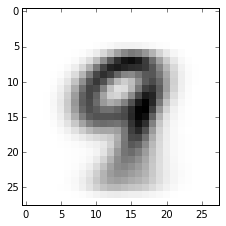

In [33]:
for c in range(10):
    coeffs_zero = init_coeffs_mnist()
    coeffs_zero[0][0,0]= (1 - rho[c][-1][-1]) * mu[c][-1][-1]
    coeffs_zero[0][0,1]= (1 - rho[c][0][(0,0)]) * mu[c][0][(0,0)][0]
    coeffs_zero[0][1,0] = (1 - rho[c][0][(0,0)]) * mu[c][0][(0,0)][1]
    coeffs_zero[0][1,1] = (1 - rho[c][0][(0,0)]) * mu[c][0][(0,0)][2]
    for h in range(1,5):
        for u in U[h]:
            coeffs_zero[h][0][u[0]][u[1]] = (1 - rho[c][h][u]) * mu[c][h][u][0]
            coeffs_zero[h][1][u[0]][u[1]] = (1 - rho[c][h][u]) * mu[c][h][u][1]
            coeffs_zero[h][2][u[0]][u[1]] = (1 - rho[c][h][u]) * mu[c][h][u][2]

    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.imshow(-pywt.waverec2(coeffs_zero, 'haar'), interpolation='nearest', cmap='gray')



## Test distribution

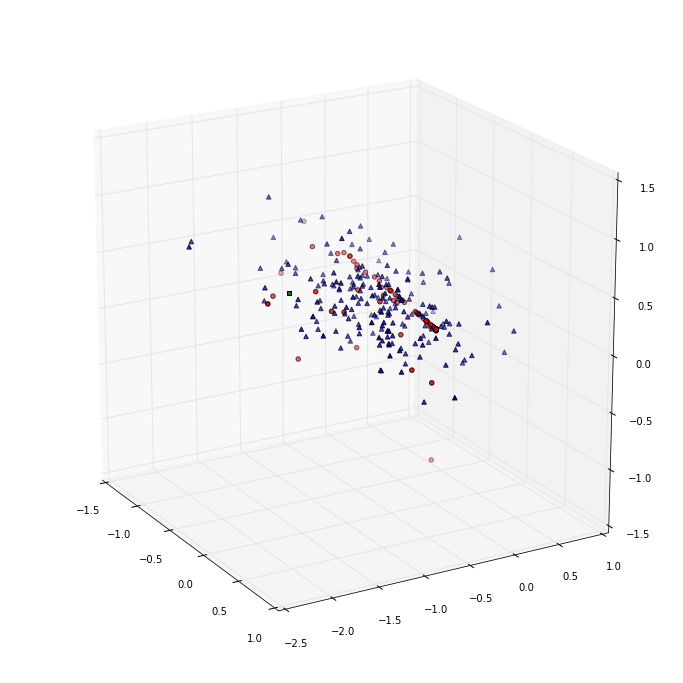

In [34]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')

c = 8
h = 3
u = (4,1)

n = 200

test2 = np.random.multivariate_normal(mu[c][h][u], Sigma[c][h][u] , n)
#test2 = np.random.multivariate_normal(mu[(c,h,u)], Sig_test * 0 , n)
#test2 = np.random.multivariate_normal(-mu[(c,h,u)], np.eye(3,3), n)
ax.scatter(test2[:,0], test2[:,1], test2[:,2],c='b', marker = '^')

#test3 = np.random.multivariate_normal(-mu[(c,h,u)], np.eye(3,3), n)
#ax.scatter(test3[:,0], test3[:,1], test3[:,2],c='g', marker = 'd')

index = np.arange(len(Data[c][h][u]))
np.random.shuffle(index)
test = np.array(Data[c][h][u])
ax.scatter(test[index[:n],0], test[index[:n],1], test[index[:n],2],c='r', marker = 'o')

v = Data_test[c][h][u][0]
ax.scatter(v[0], v[1], v[2],c='g', marker = 's')

ax.view_init(20, -30)

## Test proba

In [35]:
from scipy.stats import multivariate_normal

c_ref = 9
#h = 0
#u = (0,0)

for i in [0]:
    pi = np.ones(10) / 10
    log_score = np.zeros(10)
    mem_pi = [pi]
    for h in range(-1,5):
        print '*************************'
        print '*********' , 'h = ' , h , '************'
        print '*************************'
        for u in U[h]:
            #print U[h]
            #u = (u_ref[1],u_ref[2])
            lik = np.zeros(10)
            for c in range(10):
                v = Data_test[c_ref][h][u][i]
                if np.linalg.norm(v) < 1e-16:
                    lik[c] = rho[c][h][u]
                else:
                    if np.linalg.norm(mu[c][h][u]) > 1e-16:
                        dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
                        #print 'mean =', mu[c][h][u]
                        #print 'cov =', Sigma[c][h][u]
                        lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
                    else:
                        lik[c] = 0
                lik[c] = max(lik[c],1e-16)
            print 'lik =' + str(lik) 
            log_score += np.log(lik) 
            max_log_score = max(log_score)
            print 'log_score', log_score
            print 'max(log_score) :', max_log_score
            log_score -= max_log_score
            Z = np.sum(np.exp(log_score))
            pi = np.exp(log_score)/Z
            mem_pi += [pi]
            #for c in range(10):
            #    pi[c] = lik[c]/lik.sum()
            print 'pi =' + str(pi)
            print 'max(pi) = ',max(pi)
            sum_H = - pi * np.log(lik)
            #print np.log(lik)
            print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
            print '**** H = ',sum_H.sum()
    

*************************
********* h =  -1 ************
*************************
lik =[ 0.50263474  0.02654931  0.26605989  0.45431128  0.31538003  0.4107664
  0.44301575  0.1891527   0.47022878  0.44554379]
log_score [-0.68789154 -3.62875141 -1.32403386 -0.78897269 -1.15397691 -0.8897306
 -0.81414996 -1.66520065 -0.75453593 -0.80845975]
max(log_score) : -0.687891538352
pi =[ 0.14264634  0.00753462  0.07550706  0.12893228  0.08950398  0.11657436
  0.12572664  0.05368101  0.13344962  0.12644409]
max(pi) =  0.142646342781
**** c : 9 , h : -1 , u : -1  --->  0
**** H =  0.928837211355
*************************
********* h =  0 ************
*************************
lik =[  7.92117761e-04   1.27263634e-10   2.97246473e-04   1.55874196e-02
   2.98874212e-02   2.54655976e-02   2.62494021e-04   4.28111524e-02
   6.17834652e-03   8.14193575e-02]
log_score [ -7.14080049 -25.72562019  -8.75709121  -4.26237227  -3.97640296
  -3.87226591  -8.37154068  -4.12826576  -5.15334899  -2.62871044]
max(l

(1e-30, 10)

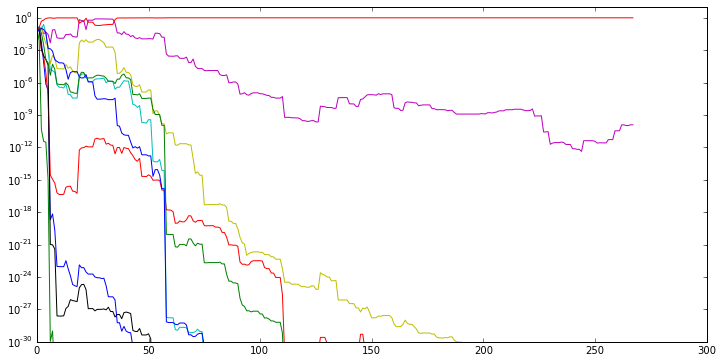

In [36]:
plt.figure(figsize = (12,6))
plt.semilogy(mem_pi)
plt.ylim([1e-30,10])
#plt.legend()

## Test reconnaissance en profondeur (saccade unique)

Tests entropie effective 

On constate un biais de confirmation de l'hypothèse initiale

In [37]:
def calcule_desc(U_tree, mem_h_u_todo):
    if U_tree == []:
        return []
    else :
        if U_tree[0] in mem_h_u_todo :
            rep = [U_tree[0]]
        else:
            rep = []
        if U_tree[1] != [] :
            rep += calcule_desc(U_tree[1], mem_h_u_todo)
        if U_tree[2] != [] :
            rep += calcule_desc(U_tree[2], mem_h_u_todo)
        if U_tree[3] != [] :
            rep += calcule_desc(U_tree[3], mem_h_u_todo)
        if U_tree[4] != [] :
            rep += calcule_desc(U_tree[4], mem_h_u_todo)    
        return rep
        
def find_desc (U_tree, pos):
    if U_tree == []:
        return None
    else :    
        if U_tree[0] == pos :
            return U_tree
        else:
            desc_1 = find_desc(U_tree[1], pos)
            if desc_1 != None:
                return desc_1
            desc_2 = find_desc(U_tree[2], pos)
            if desc_2 != None:
                return desc_2
            desc_3 = find_desc(U_tree[3], pos)
            if desc_3 != None:
                return desc_3
            desc_4 = find_desc(U_tree[4], pos)
            if desc_4 != None:
                return desc_4
    
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h,-1,-1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))] 
    rep += [(-1,-1)]
    return rep
#test =  calcule_desc(U_tree_ref)
print calcule_asc_path(4,(8,3))
       

[(4, (8, 3)), (3, (4, 1)), (2, (2, 0)), (1, (1, 0)), (0, (0, 0)), (-1, -1)]


## Métriques


In [38]:
def calc_lik(v,h,u):
    lik = np.zeros(10)
    for c in range(10):
        if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                lik[c] = rho[c][h][u]
            else:
                lik[c] = 1                
        else:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
                lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
                #lik[c] =  dist.pdf(v)
            else:
                lik[c] = 0
        lik[c] = max(lik[c],1e-16)    
    return lik

def update_log_score(log_score, lik):
    #print 'lik =' + str(lik) 
    log_score += np.log(lik) 
    max_log_score = max(log_score)
    log_score -= max_log_score
    return log_score
    
def calc_pi(log_score): # TODO
    Z = np.sum(np.exp(log_score))
    pi = np.exp(log_score)/Z
    #print 'pi =' + str(pi)
    #print 'max(pi) = ',max(pi)
    return pi
    
def calc_H_plus(log_score, v_plus, h_plus, u_plus):
    lik_plus = calc_lik(v_plus, h_plus, u_plus)
    log_score_plus = update_log_score(np.copy(log_score), lik_plus)
    pi_plus = calc_pi(log_score_plus)
    sum_H = - pi_plus * np.log(pi_plus)
    #print 'sum_H : ', sum_H
    #print np.log(lik)
    #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
    #print '**** H = ',
    return sum_H.sum()

def calc_F_plus(pi, log_score, v_plus, h_plus, u_plus):    
    lik_plus = calc_lik(v_plus, h_plus, u_plus)
    log_score_plus = update_log_score(np.copy(log_score), lik_plus)
    pi_plus = calc_pi(log_score_plus)
    sum_F = - pi_plus * (np.log(lik_plus) - np.log(pi_plus) + np.log(pi))
    #print 'sum_F : ', sum_F
    #print np.log(lik)
    #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
    #print '**** H = ',
    return sum_F.sum()   

def calc_IB_plus(pi, log_score, v_plus, h_plus, u_plus):    
    lik_plus = calc_lik(v_plus, h_plus, u_plus)
    log_score_plus = update_log_score(np.copy(log_score), lik_plus)
    pi_plus = calc_pi(log_score_plus)
    sum_IB = pi_plus * (np.log(pi_plus) - np.log(pi))
    #print 'sum_F : ', sum_F
    #print np.log(lik)
    #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
    #print '**** H = ',
    return sum_IB.sum()   

def calc_pi_MC_plus(pi,liste_u, nb_sample):
    nb_pos = len(liste_u)
    pi_MC_plus = np.zeros(nb_pos)
    tirage = np.random.multinomial(1,pi)
    c_MC = np.where(tirage==1)[0][0]
    for k in range(len(liste_u)) : 
        (h_plus, u_plus) = liste_u[k]
        for nb_obs in range(nb_sample):      
            if np.random.random() > rho[c_MC][h_plus][u_plus]:
                v_MC = np.random.multivariate_normal(mu[c_MC][h_plus][u_plus], Sigma[c_MC][h_plus][u_plus] , 1)[0]
            else:
                v_MC = np.zeros(3)
            lik_plus = calc_lik(v_MC, h_plus, u_plus)
            log_score_plus = update_log_score(np.zeros(10), lik_plus)
            pi_plus = calc_pi(log_score_plus)
            pi_MC_plus[k] += pi_plus[c_MC] / nb_sample
    return pi_MC_plus

def calc_pi_predictive_plus(pi,liste_u):
    nb_pos = len(liste_u)
    pi_predictive_plus = np.zeros(nb_pos)
    c_predictive = np.argmax(pi)
    for k in range(len(liste_u)) : 
        (h_plus, u_plus) = liste_u[k]
        '''if rho[c_predictive][h_plus][u_plus] < .5 :
            v_predictive = mu[c_predictive][h_plus][u_plus]
        else:
            v_predictive = np.zeros(3)
        lik_plus = calc_lik(v_predictive, h_plus, u_plus)'''
        lik_plus = lik_predictive[c_predictive][h_plus][u_plus]
        log_score_plus = update_log_score(np.zeros(10), lik_plus)
        pi_plus = calc_pi(log_score_plus)
        pi_predictive_plus[k] = pi_plus[c_predictive] 
    return pi_predictive_plus

def calc_E_plus(pi, v_plus, h_plus, u_plus):    
    lik_plus = calc_lik(v_plus, h_plus, u_plus)
    sum_E = pi * lik_plus
    #print 'sum_F : ', sum_F
    #print np.log(lik)
    #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
    #print '**** H = ',
    return sum_E.sum()   

## Modèle prédictif

In [39]:
lik_predictive = {}
for c in range(10):
    lik_predictive[c] = {}
    for h in range(5):
        lik_predictive[c][h] = {}
        for u in U[h]:
            log_score = np.zeros(10)
            test_pred = rho[c][h][u] < .5       
            if test_pred:
                v_predictive = mu[c][h][u]
                    #v_predictive = np.random.multivariate_normal(mu[c_predictive][h_path][u_path], Sigma[c_predictive][h_path][u_path], 1)[0]
            else:
                v_predictive = np.zeros(3)
            lik = calc_lik(v_predictive, h, u)
            lik_predictive[c][h][u] = lik

In [40]:
pi_predictive = {}
for c in range(10):
    pi_predictive[c] = {}
    for i in range(14):
        for j in range(14):
            h = 4
            u = (i, j)
            liste_path = calcule_asc_path(h, u)
            log_score_path = np.zeros(10)
            for (h_path, u_path) in liste_path[:-1]:
                test_pred = rho[c][h_path][u_path] < .5       
                if test_pred:
                    v_predictive = mu[c][h_path][u_path]
                    #v_predictive = np.random.multivariate_normal(mu[c_predictive][h_path][u_path], Sigma[c_predictive][h_path][u_path], 1)[0]
                else:
                    v_predictive = np.zeros(3)
                lik_path = calc_lik(v_predictive, h_path, u_path)
                log_score_path = update_log_score(log_score_path, lik_path)
            pi_path = calc_pi(log_score_path)
            pi_predictive[c][(h, u)] = pi_path[c]   


In [41]:
pi_predictive_eff = {}
for c in range(10):
    print c
    pi_predictive_eff[c] = []
    
    mem_h_u = []
    mem_h_u_todo = {}
    for u_add in U[4]:
        mem_h_u_todo[(4, u_add)] = 1
    
    while len(mem_h_u_todo) > 0 :    
        pi_predictive_plus = {}
        for (h, u) in mem_h_u_todo:
            liste_path = calcule_asc_path(h, u)
            log_score_path = np.zeros(10)
            for (h_path, u_path) in liste_path[:-1]:
                if (h_path, u_path) not in mem_h_u:
                    log_score_path = update_log_score(log_score_path, lik_predictive[c][h_path][u_path])
            pi_path = calc_pi(log_score_path)
            #print pi_path
            pi_predictive_plus[(h, u)] = pi_path[c] 
            #print h_plus, u_plus
        keys = pi_predictive_plus.keys()
        values = np.array(pi_predictive_plus.values())
        k = np.argmax(values)
        (h, u) = keys[k]
        #print len(pi_predictive_plus), len(mem_h_u), (values[k], (h, u))
        
        pi_predictive_eff[c] += [(values[k], (h, u))]
        mem_h_u_todo.pop((h,u)) 
        liste_path = calcule_asc_path(h, u)
        log_score_path = np.zeros(10)
        for (h_path, u_path) in liste_path[:-1]:
            if (h_path, u_path) not in mem_h_u:
                mem_h_u += [(h_path, u_path)]       
        
        #print 'CHOIX :', (h, u)
        
        
        

0
1
2
3
4
5
6
7
8
9


In [42]:
print pi_predictive_eff[5]

[(0.96639368268111925, (4, (4, 10))), (0.6446381436800166, (4, (4, 9))), (0.57418053633630228, (4, (11, 2))), (0.43296789433795729, (4, (6, 7))), (0.3432359551832781, (4, (11, 5))), (0.30749206970978088, (4, (3, 8))), (0.3088356502434601, (4, (3, 11))), (0.28840613051062897, (4, (2, 7))), (0.27372729636270804, (4, (6, 9))), (0.25517390935484485, (4, (7, 5))), (0.21254295286691094, (4, (4, 8))), (0.20833404613394302, (4, (8, 5))), (0.19372280810084999, (4, (8, 3))), (0.1865788273490008, (4, (7, 4))), (0.18424392888970653, (4, (3, 10))), (0.18122684276445475, (4, (5, 9))), (0.177793676805578, (4, (10, 5))), (0.17277103352317233, (4, (2, 9))), (0.17262021954085338, (4, (10, 6))), (0.16895580560219603, (4, (3, 9))), (0.1670767344969476, (4, (6, 10))), (0.16606494427554724, (4, (11, 4))), (0.16279447255116494, (4, (7, 6))), (0.15753165108536119, (4, (6, 6))), (0.15654812949594274, (4, (2, 8))), (0.15509302027515565, (4, (5, 7))), (0.15454103333379038, (4, (10, 4))), (0.14078333532263751, (4

In [43]:
def calc_pi_predictive_sorted(): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

### Test fonctions MAJ

In [44]:
c_ref = 8
#h = 0
#u = (0,0)
mem_out_final = []

for i in range(2):
    if i % 10 == 9:
        print i
    pi = np.ones(10) / 10
    log_score = np.zeros(10)
    mem_pi = [pi]
    mem_H = [np.sum(- pi * np.log(pi))]
    for h in range(-1,5):
        #print '*************************'
        #print '*********' , 'h = ' , h , '************'
        #print '*************************'
        for u in U[h]:
            v = Data_test[c_ref][h][u][i]
            lik = calc_lik(v,h,u)
            #print 'lik =' + str(lik) 
            log_score = update_log_score(log_score, lik)
            #print 'log_score =' + str(log_score) 
            pi_moins = pi
            pi = calc_pi(log_score)
            mem_pi += [pi]
            #print 'pi =' + str(pi)
            #print 'max(pi) = ',max(pi)
            F = np.sum(- pi * (np.log(lik) - np.log(pi) + np.log(pi_moins)))
            H = np.sum(- pi * np.log(pi))
            mem_H += [H]
            #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
            #print '**** H = ', H
            #print '**** F = ', F
    out = np.argmax(pi)
    mem_out_final += [out]
    

In [45]:
np.where(np.array(mem_out_final)==8,1,0).sum()

1

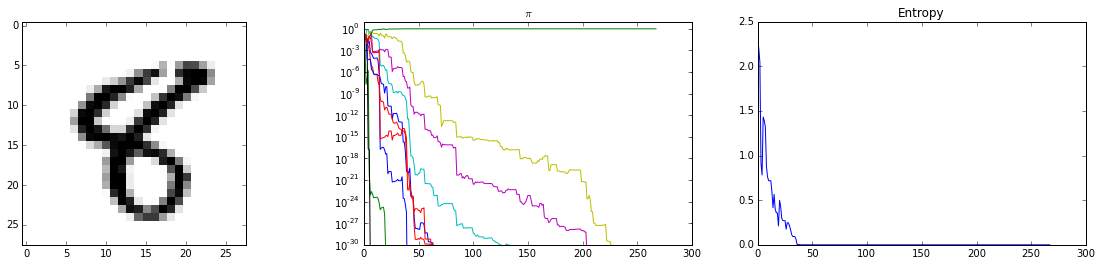

In [46]:
plt.figure(figsize = (20,4))
plt.subplot(1,3,1)
affiche_mnist(Data_test, c_ref, i)
plt.subplot(1,3,2)
plt.semilogy(mem_pi)
plt.ylim([1e-30,10])
plt.title('$\pi$')
plt.subplot(1,3,3)
plt.plot(mem_H)
plt.title('Entropy')


In [47]:
(h,u) = (4, (8, 3))
print range (h,-1,-1)

[4, 3, 2, 1, 0]


In [48]:
print U_tree[3][1][2]

[(3, (4, 1)), [(4, (8, 2)), [], [], [], []], [(4, (8, 3)), [], [], [], []], [(4, (9, 2)), [], [], [], []], [(4, (9, 3)), [], [], [], []]]


In [70]:
c_ref = 3
print '*****', c_ref, '*****'
#h = 0
#u = (0,0)

mem_out_final = []
mem_turn = []


for i in range(1,2):
    pi = np.ones(10) / 10
    log_score = np.zeros(10)
    mem_pi = [pi]
    mem_pi_copy = []
    mem_H = [np.sum(- pi * np.log(pi))]
    mem_H_copy = []
    mem_h_u = []
    mem_out = []
    (h,u) = (-1,-1)
    v = Data_test[c_ref][h][u][i]     
    lik = calc_lik(v,h,u)
    print 'lik : ', lik
    log_score = update_log_score(log_score, lik)
    #print 'log_score : ', log_score
    pi = calc_pi(log_score)
    print 'pi : ', pi
    mem_pi += [pi]
    H = np.sum(- pi * np.log(pi))
    mem_H += [H]
    print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]    
    
    (h, u) = (0, (0, 0))
    mem_U_tree = U_tree_ref = U_tree
    mem_h_u_todo = {(0, (0, 0)) : 1}
    TOUR = 0
    END = False
    VU = False
    SEUIL = False
    liste_u = []
    mem_u_final = []
    while END == False:
        print h, u
        if (h,u) not in mem_h_u:
            mem_h_u += [(h,u)]
            mem_h_u_todo.pop((h,u))
            v = Data_test[c_ref][h][u][i]     
            lik = calc_lik(v,h,u)
            print 'lik : ', lik
            log_score = update_log_score(log_score, lik)
            print 'log_score : ', log_score
            pi = calc_pi(log_score)
            print 'pi : ', pi
            mem_pi += [pi]
            H = np.sum(- pi * np.log(pi))
            print 'H : ', H
            mem_H += [H]
            out = np.argmax(pi)
            print 'pi[out] =', pi[out]
            print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.argmax(pi)
            VU = False
            if h == 4 and pi[out] > .999999 :
                SEUIL = True
        else :
            print h, u, 'déjà vu'
            #VU = True
            print ''
        if h < 4:
            if U_tree_ref[1] != [] :
                if U_tree_ref[1][0] not in mem_h_u :
                    mem_h_u_todo[U_tree_ref[1][0]] = 1
            if U_tree_ref[2] != [] :
                if U_tree_ref[2][0] not in mem_h_u :
                    mem_h_u_todo[U_tree_ref[2][0]] = 1
            if U_tree_ref[3] != [] :
                if U_tree_ref[3][0] not in mem_h_u :
                    mem_h_u_todo[U_tree_ref[3][0]] = 1
            if U_tree_ref[4] != [] :
                if U_tree_ref[4][0] not in mem_h_u :
                    mem_h_u_todo[U_tree_ref[4][0]] = 1
            liste_u_desc = calcule_desc(U_tree_ref, mem_h_u_todo)
            '''for i_fils in range(1,5):
                if U_tree_ref[i_fils] != [] and U_tree_ref[i_fils] not in liste_u and U_tree_ref[i_fils][0] not in mem_h_u:
                    liste_u+= [U_tree_ref[i_fils]] 
            print 'TOUR = ',TOUR, 'h = ', h, 'len(liste_u) =', len(liste_u)'''
            print 'liste_u_desc :', liste_u_desc
            for pos_test in mem_h_u:
                if pos_test in liste_u_desc:
                    liste_u_desc.remove(pos_test)
            if len(liste_u_desc) == 0 :
                print 'HUM!!', 'h = ', h, 'u = ', u
                c_in = raw_input()
                h = 0
                u = (0,0)
                mem_U_tree = U_tree_ref = U_tree
            else:
                #c = raw_input()
                '''H_plus = np.zeros(len(liste_u_desc))
                F_plus = np.zeros(len(liste_u_desc))
                E_plus = np.zeros(len(liste_u_desc))
                IB_plus = np.zeros(len(liste_u_desc))
                for k in []: #range(len(liste_u_desc)):
                    (h_plus, u_plus) = liste_u_desc[k] 
                    v_plus = Data_test[c_ref][h_plus][u_plus][i]
                    H_plus[k] = calc_H_plus(log_score, v_plus, h_plus, u_plus)
                    F_plus[k] = calc_F_plus(pi, log_score, v_plus, h_plus, u_plus)
                    E_plus[k] = calc_E_plus(pi, v_plus, h_plus, u_plus)
                    IB_plus[k] = calc_IB_plus(pi, log_score, v_plus, h_plus, u_plus)'''
                #pi_MC_plus = calc_pi_MC_plus(pi, liste_u_desc, 10)
                #print 'pi_MC_plus :', pi_MC_plus
                pi_predictive_plus = calc_pi_predictive_plus(pi,liste_u_desc)
                #print 'pi_predictive_plus :', pi_predictive_plus
                #k_plus = np.argmin(H_plus) #where(H_plus == min(H_plus))[0][0]           
                #k_plus =  np.argmax(F_plus)
                #k_plus =  np.argmin(E_plus)
                #k_plus =  np.argmax(IB_plus)
                k_plus =  np.argmax(pi_predictive_plus)
                #k_plus =  np.argmax(pi_MC_plus)
                #print 'H plus :', H_plus
                #print 'F plus :', F_plus
                #print 'k_plus :', k_plus
                (h, u) = liste_u_desc[k_plus]
                mem_U_tree = U_tree_ref                
                U_tree_ref = find_desc (U_tree_ref, liste_u_desc[k_plus]) #U_tree_ref[k_plus + 1]
                #print U_tree_ref
                print ''
        else:
            mem_u_final += [u]
            mem_pi_copy += [list(mem_pi)]
            mem_H_copy += [list(mem_H)]
            mem_out += [out]
            if TOUR == 50  or SEUIL:    
                END = True
                print '************************************'
                print '******         FINI          *******'
                print '************************************'  
                mem_out_final += [out]
                mem_turn += [TOUR]
            else:
                TOUR += 1
                print '************************************'
                print '******       TOUR    ' + str(TOUR) + '        ******'
                print '************************************'
                h = 0
                u = (0,0)
                mem_U_tree = U_tree_ref = U_tree
        

***** 3 *****
lik :  [ 0.47564618  0.01808874  0.2331514   0.43169028  0.27123201  0.38488875
  0.40988596  0.15157293  0.44717229  0.40272556]
pi :  [ 0.147439    0.00560708  0.07227139  0.13381371  0.08407547  0.11930635
  0.12705489  0.046984    0.13861277  0.12483534]
**** c : 3 , h : -1 , u : -1  --->  0
0 (0, 0)
lik :  [ 0.02212381  0.00329394  0.1641913   0.13230074  0.01990622  0.12533192
  0.48756293  0.0270903   0.11006694  0.01492716]
log_score :  [-2.94396986 -8.11792468 -1.65257808 -1.25251232 -3.61129141 -1.42137845
  0.         -3.8850558  -1.40126565 -3.50386041]
pi :  [  2.51269859e-02   1.42272304e-04   9.14081074e-02   1.36373840e-01
   1.28921791e-02   1.15184341e-01   4.77188819e-01   9.80464698e-03
   1.17524475e-01   1.43543331e-02]
H :  1.6001881595
pi[out] = 0.477188818973
**** c : 3 , h : 0 , u : (0, 0)  --->  6
liste_u_desc : [(1, (0, 0)), (1, (0, 1)), (1, (1, 0)), (1, (1, 1))]

1 (1, 0)
lik :  [  2.70942084e-03   3.97826023e-06   1.25478862e-12   1.27563878e

In [71]:
np.where(np.array(mem_out_final)==3,1,0).sum()

1

## Affichage

coords : (20.5, 12.5)
coords : (12.5, 20.5)
coords : (16.5, 20.5)
coords : (8.5, 8.5)


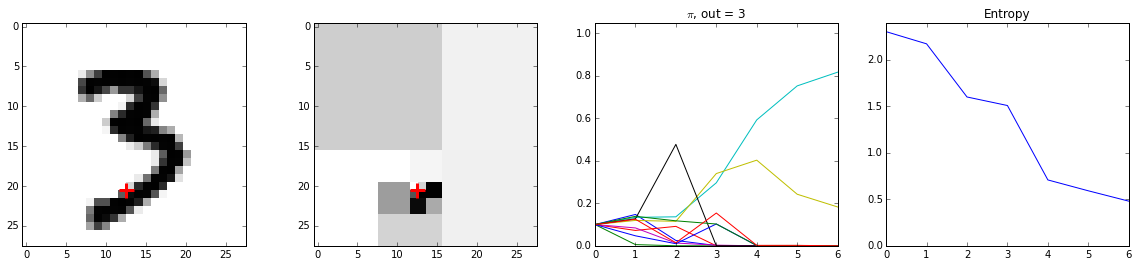

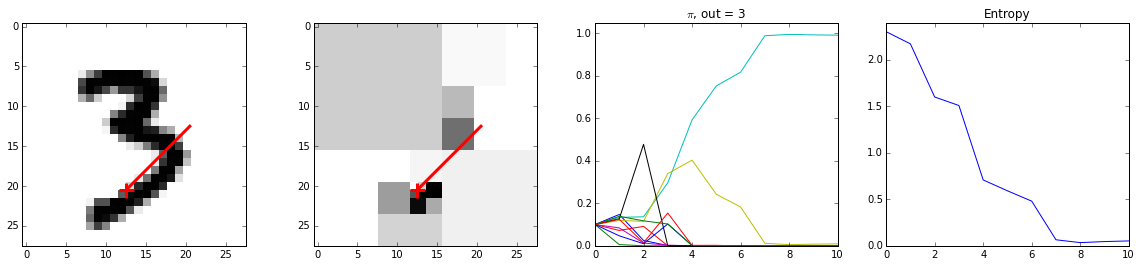

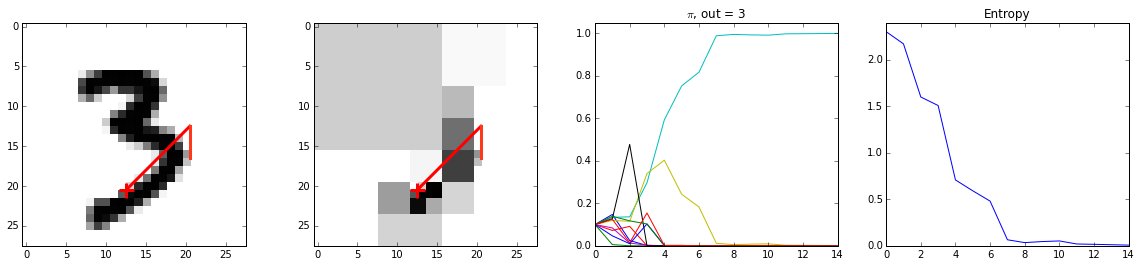

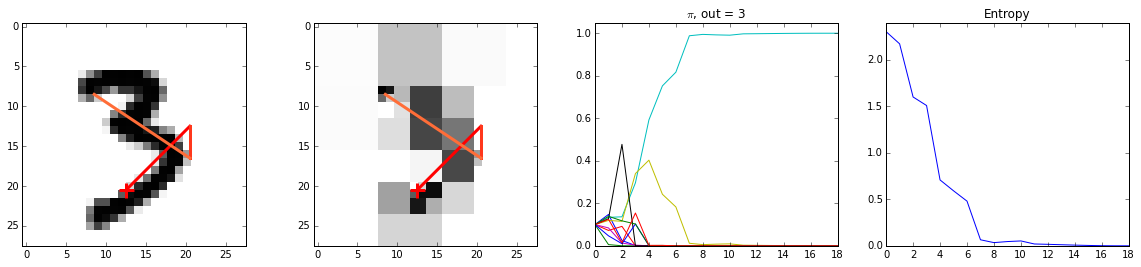

In [82]:
coeffs_aff = init_coeffs_mnist()
cpt = 0
path_i = []
path_j = []
for u in mem_u_final :
    path_i += [U[4][u][0]]
    path_j += [U[4][u][1]]
    plt.figure(figsize = (20,4))
    plt.subplot(1,4,1)
    affiche_mnist(Data_test, c_ref, i)
    affiche_path_mnist(path_i, path_j)
    plt.plot(path_j[0], path_i[0],'+r', markersize = 15, mew = 3)
    #plt.title(cpt)
    plt.subplot(1,4,2)    
    coord = U[4][u]  
    print 'coords :', coord
    affiche_mnist_coord(Data_test, coeffs_aff, c_ref, i, coord)
    affiche_path_mnist(path_i, path_j)
    plt.plot(path_j[0], path_i[0],'+r', markersize = 15, mew = 3)
    
    plt.subplot(1,4,3)
    plt.plot(mem_pi_copy[cpt])
    plt.title('$\pi$, out = '+str(mem_out[cpt]))
    plt.ylim([0,1.05])
    plt.subplot(1,4,4)
    plt.plot(mem_H_copy[cpt])
    plt.title('Entropy')
    plt.ylim([0,2.4])
    
    cpt += 1

**Commentaire** : test avec `pi_MC_plus` : les saccades se focalisent sur les petits details, difficulté à atteindre un autre quart d'image que le quart initial (niveau h = 1 trop peu discriminant) ==> il faut appliquer cette technique sur la totalité de l'image.

## Predictive coding

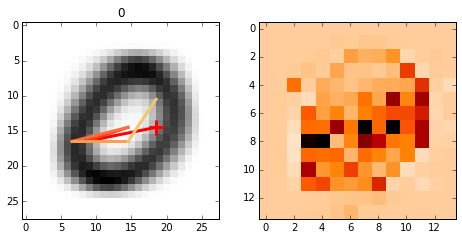

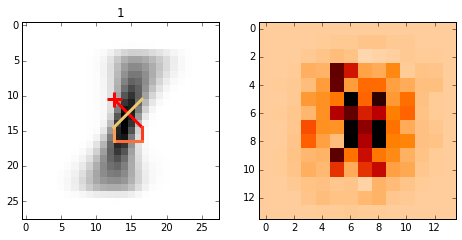

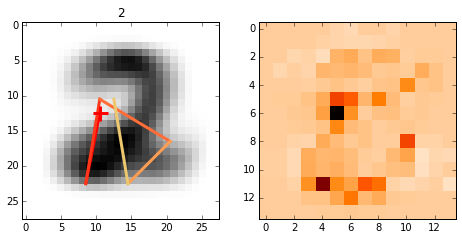

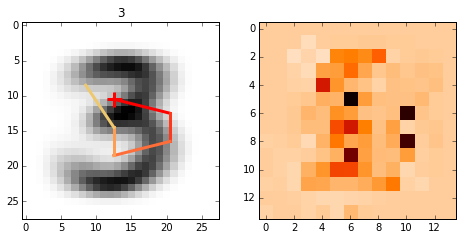

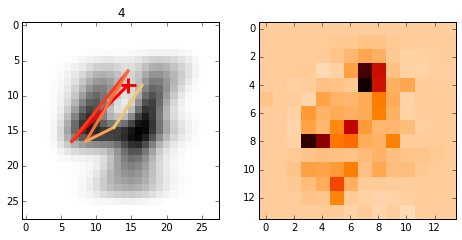

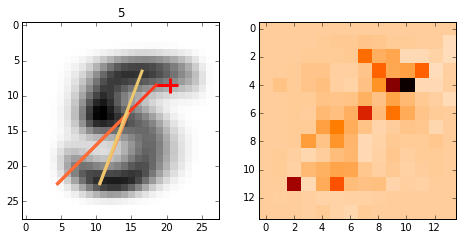

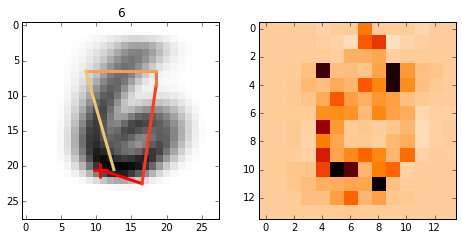

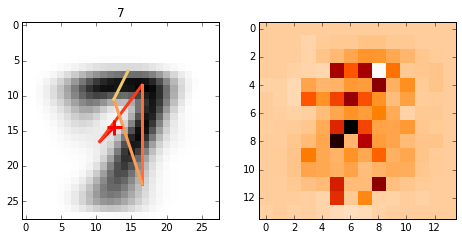

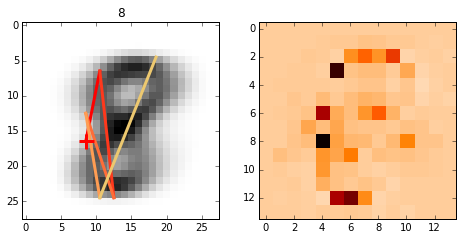

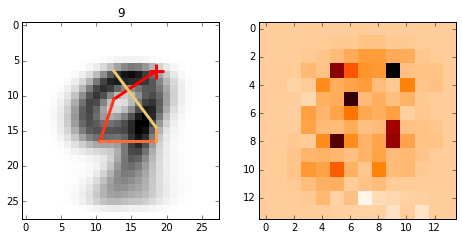

In [83]:
pi_predictive_sorted = calc_pi_predictive_sorted()
for c in range(10):
    image_moy = np.mean(np.array(data_visu[c]),0)
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.imshow(-image_moy, interpolation='nearest', cmap='gray')
    plt.title(c)
    path_i = []
    path_j = []
    image_pi = np.zeros((14,14))
    for cpt in range(6):
        #(pi_pred,(h,u)) = pi_predictive_sorted[c].pop()
        (pi_pred,(h,u)) = pi_predictive_eff[c][cpt]
        #print c,pi_pred
        path_i += [U[4][u][0]]
        path_j += [U[4][u][1]]
    affiche_path_mnist(path_i, path_j)
    plt.plot(path_j[0], path_i[0],'+r', markersize = 15, mew = 3)
    
    plt.subplot(132)
    for cpt in range(196):
        (pi_pred,(h,u)) = pi_predictive_eff[c][cpt]
        image_pi[u[0],u[1]] = pi_pred
        
    
    plt.imshow(image_pi, interpolation='nearest', cmap = 'gist_heat_r', vmin = 0, vmax = 1)
    
    


1
2
3
4
5
6
7
8
9
10


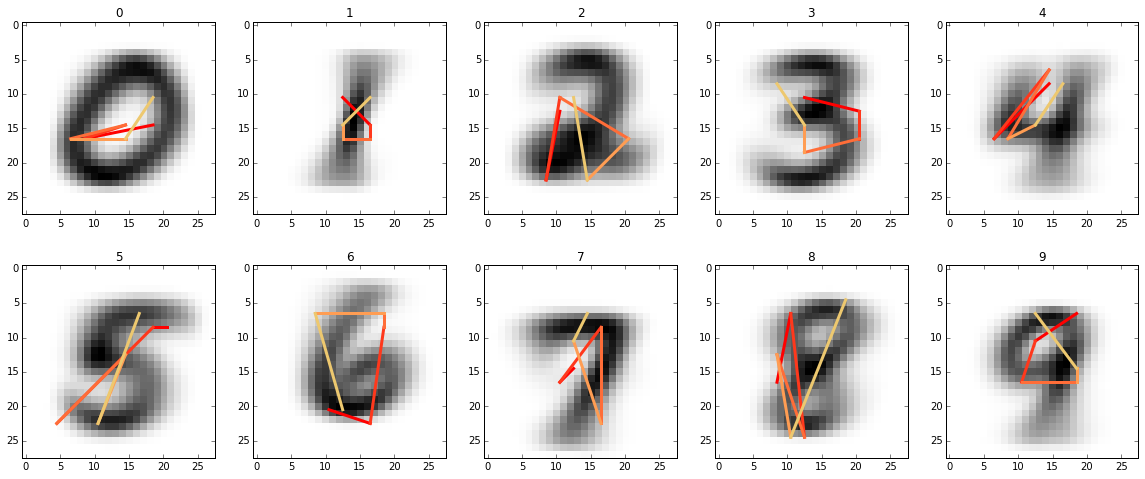

In [53]:
pi_predictive_sorted = calc_pi_predictive_sorted()
plt.figure(figsize=(20,8))
for c in range(10):
    image_moy = np.mean(np.array(data_visu[c]),0)
    num = 1 + c
    print num
    plt.subplot(2, 5, num)
    plt.imshow(-image_moy, interpolation='nearest', cmap='gray')
    plt.title(c)
    path_i = []
    path_j = []
    image_pi = np.zeros((14,14))
    for cpt in range(6):
        #(pi_pred,(h,u)) = pi_predictive_sorted[c].pop()
        (pi_pred,(h,u)) = pi_predictive_eff[c][cpt]
        #print c,pi_pred
        path_i += [U[4][u][0]]
        path_j += [U[4][u][1]]
    affiche_path_mnist(path_i, path_j)    
    


## Modèle baseline

In [54]:

mem_out_final = []
mem_turn = []

for i in range(100):
    x = mnist.test.images[i]
    scores = []
    for c in range(10):
        scores += [np.dot(x, lin_mnist[c])]
    mem_out_final += [np.argmax(scores) == mnist.test.labels[i]]
        

In [55]:
np.sum(mem_out_final)

65

## Modèle prédictif rapide

In [56]:
c_ref = 8
print '*****', c_ref, '*****'

mem_out_final = []
mem_turn = []

for i in range(1):
    pi = np.ones(10) / 10
    log_score = np.zeros(10)
    mem_pi = [pi]
    mem_pi_copy = []
    mem_H = [np.sum(- pi * np.log(pi))]
    mem_H_copy = []
    mem_h_u = []
    mem_out = []
    
    # Initialisation
    (h,u) = (-1,-1)
    v = Data_test[c_ref][h][u][i]     
    lik = calc_lik(v,h,u)
    print 'lik : ', lik
    log_score = update_log_score(log_score, lik)
    #print 'log_score : ', log_score
    pi = calc_pi(log_score)
    print 'pi : ', pi
    mem_pi += [pi]
    H = np.sum(- pi * np.log(pi))
    mem_H += [H]
    print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]    
    
    (h, u) = (0, (0, 0))
    mem_h_u_todo = {(0, (0, 0)):1}
    for u_add in U[4]:
        mem_h_u_todo[(4, u_add)] = 1

    
    TOUR = 0
    END = False
    VU = False
    SEUIL = False
    liste_u = []
    mem_u_final = []

    # Premiere estimation pi (0,(0,0))
    mem_h_u += [(h,u)]
    mem_h_u_todo.pop((h,u))
    v = Data_test[c_ref][h][u][i]     
    lik = calc_lik(v,h,u)
    print 'lik : ', lik
    log_score = update_log_score(log_score, lik)
    print 'log_score : ', log_score
    pi = calc_pi(log_score)
    print 'pi : ', pi
    mem_pi += [pi]
    H = np.sum(- pi * np.log(pi))
    print 'H : ', H
    mem_H += [H]
    print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.argmax(pi)
    out = np.argmax(pi)
    
    pi_predictive_sorted = {} #calc_pi_predictive_sorted()
    for c in range(10):
        pi_predictive_sorted[c] = sorted(pi_predictive_eff[c])

    while END == False:
        
        # CHOIX
        c_predictive = np.argmax(pi)
        
        #print 'pi_predictive_sorted[', c_predictive, '] :', pi_predictive_sorted[c_predictive]
        #c = raw_input()
        (pi_plus, (h,u)) = pi_predictive_sorted[c_predictive].pop()
        
        if (h, u) in mem_h_u_todo:
            mem_h_u_todo.pop((h,u))
        else:
            while (h, u) not in mem_h_u_todo:
                (pi_plus, (h,u)) = pi_predictive_sorted[c_predictive].pop()
            mem_h_u_todo.pop((h,u))
        #print h_plus, u_plus
        print 'CHOIX : u =', u        
        
        # LECTURE
        liste_path = calcule_asc_path(h, u)
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                v = Data_test[c_ref][h_path][u_path][i] 
                lik_path = calc_lik(v, h_path, u_path)
                log_score = update_log_score(log_score, lik_path)
                mem_h_u += [(h_path, u_path)]
                pi = calc_pi(log_score)
                print 'pi : ', pi
                mem_pi += [pi]
                H = np.sum(- pi * np.log(pi))
                out = np.argmax(pi)
                print 'pi[out] : ', pi[out]
                print 'H : ', H
                mem_H += [H]
                
        print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.argmax(pi)
        mem_u_final += [u]
        mem_pi_copy += [list(mem_pi)]
        mem_H_copy += [list(mem_H)]
        mem_out += [out]
        #if TOUR == len(U[4]) - 1 or pi[out] > .999999:
        if TOUR == 20 or pi[out] > .9999:
        #if TOUR == 8 or pi[out] > .999:
            END = True
            print '************************************'
            print '******         FINI          *******'
            print '************************************'        
            mem_out_final += [out]
            mem_turn += [TOUR]
        else:
            TOUR += 1
            print '************************************'
            print '******       TOUR    ' + str(TOUR) + '        ******'
            print '************************************'


***** 8 *****
lik :  [ 0.50613684  0.23649266  0.49193248  0.47577732  0.59307512  0.48432383
  0.53347716  0.55519451  0.48115288  0.58933263]
pi :  [ 0.10231404  0.04780628  0.09944267  0.09617695  0.11988835  0.0979046
  0.1078408   0.1122309   0.0972636   0.11913182]
**** c : 8 , h : -1 , u : -1  --->  4
lik :  [ 0.00911929  0.00301814  0.02944686  0.01498078  0.02916821  0.0318174
  0.00209217  0.13767564  0.19400838  0.06064971]
log_score :  [-3.006887   -4.87352788 -1.86315782 -2.57236837 -1.68568583 -1.80131926
 -4.42646972 -0.19986741  0.         -0.95998083]
pi :  [ 0.01733269  0.00268037  0.0543978   0.02676548  0.06496156  0.05786787
  0.0041913   0.28703785  0.35054234  0.13422274]
H :  1.70217316557
**** c : 8 , h : 0 , u : (0, 0)  --->  8
CHOIX : u = (8, 4)
pi :  [ 0.01671569  0.00120782  0.05098909  0.02426438  0.07341023  0.05340276
  0.00426045  0.30365103  0.32137642  0.15072213]
pi[out] :  0.321376415057
H :  1.70187079042
pi :  [  8.32362209e-02   1.41881502e-15   

In [57]:
np.where(np.array(mem_out_final)==8,1,0).sum()

1

In [58]:
np.where(np.array(mem_out_final)!=1)

(array([0]),)

In [59]:
np.mean(mem_turn)

7.0

## Modèle prédictif exact

In [60]:
c_ref = 3
print '*****', c_ref, '*****'
#h = 0
#u = (0,0)
mem_out_final = []
mem_turn = []

for i in range(1,2):
    pi = np.ones(10) / 10
    log_score = np.zeros(10)
    mem_pi = [pi]
    mem_pi_copy = []
    mem_H = [np.sum(- pi * np.log(pi))]
    mem_H_copy = []
    mem_h_u = []
    mem_out = []
    
    # Initialisation
    (h,u) = (-1,-1)
    v = Data_test[c_ref][h][u][i]     
    lik = calc_lik(v,h,u)
    print 'lik : ', lik
    log_score = update_log_score(log_score, lik)
    #print 'log_score : ', log_score
    pi = calc_pi(log_score)
    print 'pi : ', pi
    mem_pi += [pi]
    H = np.sum(- pi * np.log(pi))
    mem_H += [H]
    print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]    
    
    (h, u) = (0, (0, 0))
    mem_h_u_todo = {(0, (0, 0)):1}
    for u_add in U[4]:
        mem_h_u_todo[(4, u_add)] = 1

    TOUR = 0
    END = False
    VU = False
    SEUIL = False
    liste_u = []
    mem_u_final = []

    # Premiere estimation pi (0,(0,0))
    mem_h_u += [(h,u)]
    mem_h_u_todo.pop((h,u))
    v = Data_test[c_ref][h][u][i]     
    lik = calc_lik(v,h,u)
    print 'lik : ', lik
    log_score = update_log_score(log_score, lik)
    print 'log_score : ', log_score
    pi = calc_pi(log_score)
    print 'pi : ', pi
    mem_pi += [pi]
    H = np.sum(- pi * np.log(pi))
    print 'H : ', H
    mem_H += [H]
    print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.argmax(pi)
    out = np.argmax(pi)

    while END == False:
        
        # CHOIX
        pi_predictive_plus = {}
        c_predictive = np.argmax(pi)
        for (h_plus, u_plus) in mem_h_u_todo:
            liste_path = calcule_asc_path(h_plus, u_plus)
            log_score_path = np.zeros(10)
            for (h_path, u_path) in liste_path[:-1]:
                if (h_path, u_path) not in mem_h_u:
                    '''#test_pred = np.random.random() > rho[c_predictive][h_path][u_path]
                    test_pred = rho[c_predictive][h_path][u_path] < .5       
                    if test_pred:
                        v_predictive = mu[c_predictive][h_path][u_path]
                        #v_predictive = np.random.multivariate_normal(mu[c_predictive][h_path][u_path], Sigma[c_predictive][h_path][u_path], 1)[0]
                    else:
                        v_predictive = np.zeros(3)
                    lik_path = calc_lik(v_predictive, h_path, u_path)
                    log_score_path = update_log_score(log_score_path, lik_path)'''
                    log_score_path = update_log_score(log_score_path, lik_predictive[c_predictive][h_path][u_path])
            pi_path = calc_pi(log_score_path)
            pi_predictive_plus[(h_plus, u_plus)] = pi_path[c_predictive] 
            #print h_plus, u_plus
        
        keys = pi_predictive_plus.keys()
        values = np.array(pi_predictive_plus.values())
        k_next = np.argmax(values) #np.argmin(values) #
        (h, u) = keys[k_next]
        
        print 'CHOIX :', (h, u)
        
        # LECTURE
        mem_h_u_todo.pop((h,u))
        liste_path = calcule_asc_path(h, u)
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                v = Data_test[c_ref][h_path][u_path][i] 
                lik_path = calc_lik(v, h_path, u_path)
                log_score = update_log_score(log_score, lik_path)
                mem_h_u += [(h_path, u_path)]
                pi = calc_pi(log_score)
                print 'pi : ', pi
                mem_pi += [pi]
                H = np.sum(- pi * np.log(pi))
                out = np.argmax(pi)
                print 'pi[out] : ', pi[out]
                print 'H : ', H
                mem_H += [H]
                
        print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.argmax(pi)
        mem_u_final += [u]
        mem_pi_copy += [list(mem_pi)]
        mem_H_copy += [list(mem_H)]
        mem_out += [out]
        #if TOUR == 50 or (TOUR >5 and pi[out] > .99999):   
        if TOUR == len(U[4]) - 1 or pi[out] > .999999:
            END = True
            print '************************************'
            print '******         FINI          *******'
            print '************************************'   
            mem_out_final += [out]
            mem_turn += [TOUR]
        else:
            TOUR += 1
            print '************************************'
            print '******       TOUR    ' + str(TOUR) + '        ******'
            print '************************************'
        

***** 3 *****
lik :  [ 0.47564618  0.01808874  0.2331514   0.43169028  0.27123201  0.38488875
  0.40988596  0.15157293  0.44717229  0.40272556]
pi :  [ 0.147439    0.00560708  0.07227139  0.13381371  0.08407547  0.11930635
  0.12705489  0.046984    0.13861277  0.12483534]
**** c : 3 , h : -1 , u : -1  --->  0
lik :  [ 0.02212381  0.00329394  0.1641913   0.13230074  0.01990622  0.12533192
  0.48756293  0.0270903   0.11006694  0.01492716]
log_score :  [-2.94396986 -8.11792468 -1.65257808 -1.25251232 -3.61129141 -1.42137845
  0.         -3.8850558  -1.40126565 -3.50386041]
pi :  [  2.51269859e-02   1.42272304e-04   9.14081074e-02   1.36373840e-01
   1.28921791e-02   1.15184341e-01   4.77188819e-01   9.80464698e-03
   1.17524475e-01   1.43543331e-02]
H :  1.6001881595
**** c : 3 , h : 0 , u : (0, 0)  --->  6
CHOIX : (4, (10, 5))
pi :  [  3.02279515e-02   6.50898202e-06   5.39022704e-02   1.48897582e-01
   8.84405789e-03   1.12127714e-01   4.94695097e-01   3.75870220e-03
   1.32919135e-01  

In [61]:
np.where(np.array(mem_out_final)==0,1,0).sum()

0

In [62]:
i

1

In [63]:
np.log(lik)

array([-3.81110106, -5.71567146, -1.80672307, -2.02267764, -3.91672292,
       -2.07678972, -0.71833591, -3.60857965, -2.20666655, -4.20457269])

In [64]:
np.random.random()

0.6347609462938573

In [65]:
lik_test = [6.47120236e+00,   1.00000000e-16,   5.20558153e-01,   1.37438396e-02,
   2.70854267e-05,   1.95244077e-01,   2.48980440e+00,   1.61746086e-04,
   3.05114329e-02,   1.48932662e-03]
log_score_test = [-44.72913926, -226.20581543,   -2.30103965,  -30.98412798,  -46.28824072,
  -32.42211479,  -30.40021047, -100.38374515,    0.,          -52.30459006]
print np.log(lik_test)

[  1.86736193 -36.84136149  -0.65285367  -4.28716458 -10.51651473
  -1.63350483   0.91220415  -8.72948282  -3.48965382  -6.50943119]


In [66]:
log_score_plus = log_score_test + np.log(lik_test)

In [67]:
log_score_plus

array([ -42.86177733, -263.04717692,   -2.95389332,  -35.27129256,
        -56.80475545,  -34.05561962,  -29.48800632, -109.11322797,
         -3.48965382,  -58.81402125])

In [68]:
b_i_inf = 2**(h-5) * i_moins

NameError: name 'i_moins' is not defined

In [ ]:
a = np.random.multinomial(1,[.25, .25, .25, .25])
np.where(a==1)[0][0]

In [ ]:
l = range(10)
print l.pop(), l

In [ ]:
x = range(5)
y = sorted(x, reverse = True)
y[0] = 2
print x
print y

In [ ]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(path_i)))

In [ ]:
plt.plot(np.random.rand(10), color = colors[1])

In [ ]:
len(path_i)

In [1]:
14 * 14 + 7 * 7 + 4 * 4 + 2 * 2 + 1

266